# Lecture 35: Nearest Neighbor

In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
%matplotlib inline
np.set_printoptions(legacy='1.13')

NUM_REPETITIONS = 5

## Recap previous lecture

In [2]:
raw_ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
    
def ckd_label(number):
    if number == 0:
        return "notckd"
    elif number == 1:
        return "ckd"
    else:
        return "unknown"
  
ckd = raw_ckd.with_column(
    'Class', raw_ckd.apply(ckd_label, 'Class')
)    
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,ckd


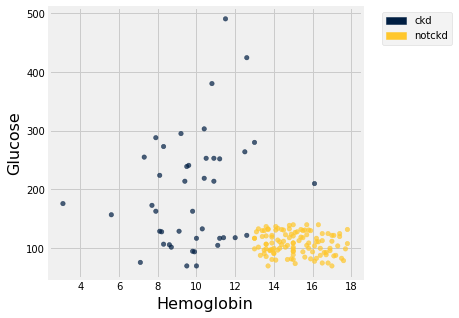

In [3]:
hgb_glc = ckd.select('Hemoglobin', 'Glucose', 'Class')
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')

In [4]:
def distance(a, b):
    """Returns the distance between a and b, where a and b
    are both arrays representing points."""
    return np.sqrt(np.sum((a - b)**2))

In [5]:
new_point = make_array(13, 150)

def distance_from_new(row):
    """Return the distance between row and new_point.
    Row is an input to the function and can change every
    time the function is called. new_point is the same
    every time, though."""
    return distance(np.array(row), new_point)

In [6]:
r0 = hgb_glc.row(0)
r0

Row(Hemoglobin=11.199999999999999, Glucose=117, Class='ckd')

In [7]:
#distance_from_new(r0) #ERROR

In [8]:
distance_from_new(hgb_glc.drop('Class').row(0))

33.049054449408985

In [9]:
distances = hgb_glc.with_column(
    'Distance', hgb_glc.drop('Class').apply(distance_from_new)
).sort('Distance')

distances

Hemoglobin,Glucose,Class,Distance
5.6,157,ckd,10.1863
15,140,notckd,10.198
15.7,140,notckd,10.3581
16.3,140,notckd,10.5304
14.8,139,notckd,11.1463
13.6,137,notckd,13.0138
14.1,137,notckd,13.0465
9.8,163,ckd,13.3881
7.9,163,ckd,13.9646
14.2,134,notckd,16.0449


**Q:** In your own words, describe what `apply` does.

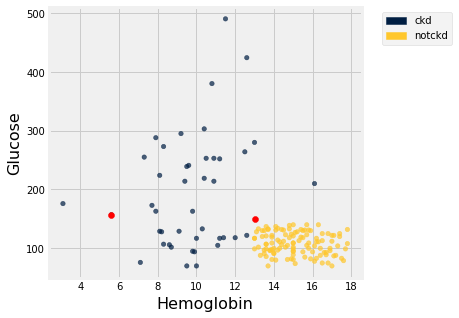

In [10]:
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13, 5.6], [150, 157], color='red');

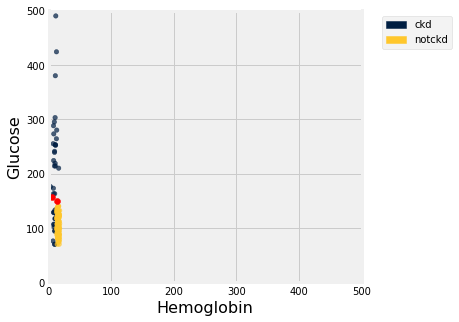

In [11]:
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13, 5.6], [150, 157], color='red');
plots.xlim(0,500);
plots.ylim(0,500);

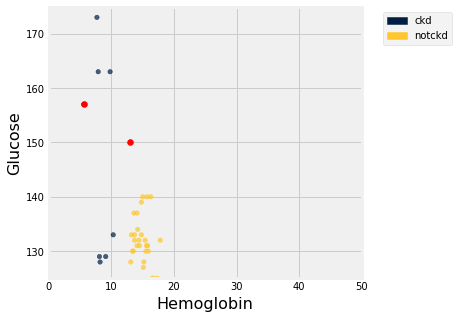

In [12]:
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13, 5.6], [150, 157], color='red');
plots.xlim(0,50);
plots.ylim(125,175);

**Accounting for scale.**

In [13]:
def standard_units(array):
    """Convert array to standard units."""
    return (array - array.mean()) / array.std()
    
def standardize(t):
    "Covert table t to standard units."
    su = Table()
    for label in t.labels:
        su = su.with_column(label + ' (su)', standard_units(t.column(label)))
    return su

def in_su(value, array):
    """Return value in standard units according to 
    the distribution of array."""
    return (value - array.mean()) / array.std()

In [14]:
hgb_glc_su = standardize(hgb_glc.drop('Class'))\
  .with_column('Class', hgb_glc.column('Class'))
hgb_glc_su

Hemoglobin (su),Glucose (su),Class
-0.865744,-0.221549,ckd
-1.45745,-0.947597,ckd
-1.00497,3.84123,ckd
-2.81488,0.396364,ckd
-2.08395,0.643529,ckd
-1.35303,-0.561402,ckd
-0.413266,2.04928,ckd
-1.28342,-0.947597,ckd
-1.10939,1.87936,ckd
-1.35303,0.489051,ckd


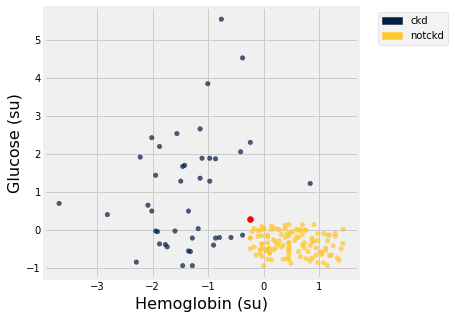

In [15]:
hgb_glc_su.scatter('Hemoglobin (su)', 'Glucose (su)', colors='Class')
x_su = in_su(13, hgb_glc.column('Hemoglobin'))
y_su = in_su(150, hgb_glc.column('Glucose'))
plots.scatter(x_su, y_su, color='red');

In [16]:
new_point = make_array(x_su, y_su)

def distance_from_new(row):
    """Return the distance between row and new_point."""
    return distance(np.array(row), new_point)
       
distances = hgb_glc_su.with_column(
    'Distance', hgb_glc_su.drop('Class').apply(distance_from_new)
).sort('Distance')

distances

Hemoglobin (su),Glucose (su),Class,Distance
-0.169624,0.025616,notckd,0.271683
-0.0304002,0.0874074,notckd,0.289727
-0.100012,-0.0207275,notckd,0.338877
-0.20443,-0.0516231,notckd,0.34163
-0.0652062,-0.0207275,notckd,0.354599
0.00440582,0.025616,notckd,0.358228
0.00440582,0.0101682,notckd,0.369702
0.14363,0.0874074,notckd,0.432337
-0.37846,-0.14431,ckd,0.454394
0.14363,-0.00527964,notckd,0.482425


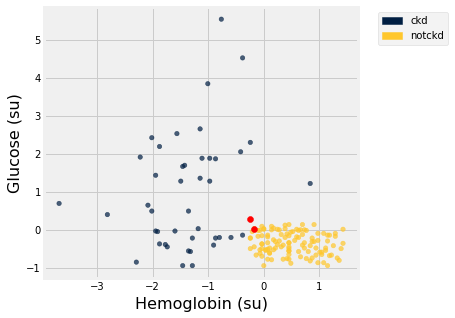

In [17]:
hgb_glc_su.scatter('Hemoglobin (su)', 'Glucose (su)', colors='Class')
close_x = distances.column('Hemoglobin (su)').item(0)
close_y = distances.column('Glucose (su)').item(0)
plots.scatter([x_su, close_x], [y_su, close_y], color='red');

**Nearest Neighbor Classifier.**

In [18]:
def hgb_glc_nn_classifier_su(new_point_su):
    """Return the hgb/glc classification of new_point_su, which
    should be in standard units already."""
    def distance_from_new(row):
        return distance(np.array(row), new_point_su)
    
    distances = hgb_glc_su.with_column(
        'Distance', hgb_glc_su.drop('Class').apply(distance_from_new)
    )
    return distances.sort('Distance').column('Class').item(0)

def hgb_glc_nn_classifier_ou(new_point):
    """Return the hgb/glc classification of new_point, which
    should still be in original units."""
    hgb_su = in_su(new_point.item(0), hgb_glc.column('Hemoglobin'))
    glc_su = in_su(new_point.item(1), hgb_glc.column('Glucose'))
    return hgb_glc_nn_classifier_su(make_array(hgb_su, glc_su))

In [19]:
hgb_glc_nn_classifier_ou(make_array(13, 150))

'notckd'

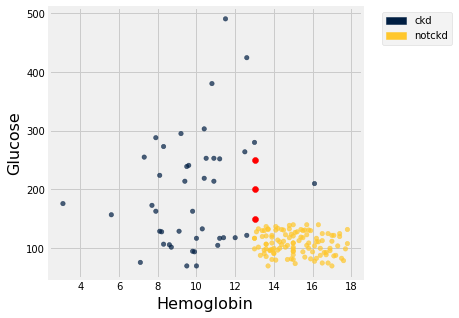

In [20]:
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13,13,13], [150,200,250], color='red');

**Q:** What should the classification of (13, 200) be?

A.  ckd  
B.  notckd  

In [21]:
hgb_glc_nn_classifier_ou(make_array(13, 200))

'ckd'

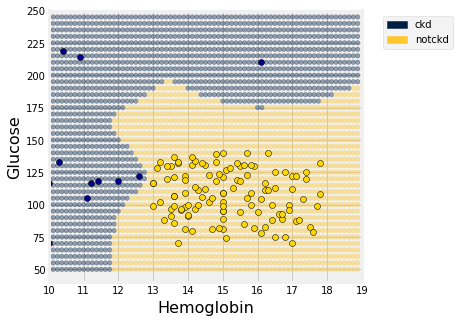

In [22]:
decisions = Table(hgb_glc.labels)
for hgb in np.arange(10, 19, .125):
    for glc in np.arange(50, 250, 5):
        predicted = hgb_glc_nn_classifier_ou(make_array(hgb, glc))
        decisions.append([hgb, glc, predicted])
decisions.scatter(0, 1, colors='Class', alpha=0.4)
plots.xlim(10,19)
plots.ylim(40,250)
notckd_pts = hgb_glc.where('Class', 'notckd')
ckd_pts = hgb_glc.where('Class', 'ckd')
plots.scatter(notckd_pts.column(0), notckd_pts.column(1), c='gold', edgecolor='k');
plots.scatter(ckd_pts.column(0), ckd_pts.column(1), c='darkblue', edgecolor='k');

## Training and Testing

In [23]:
shuffled_hgb_glc = hgb_glc.sample(with_replacement=False)
half = int(hgb_glc.num_rows / 2)
train_hgb_glc = shuffled_hgb_glc.take(np.arange(0, half))
test_hgb_glc  = shuffled_hgb_glc.take(np.arange(half, hgb_glc.num_rows))

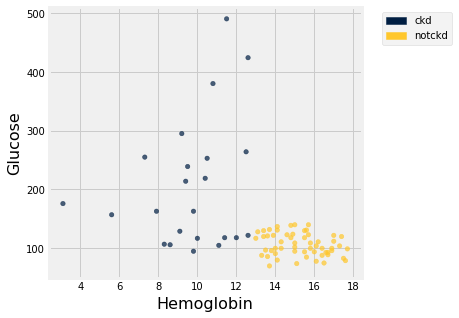

In [24]:
train_hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')

In [25]:
def train_nn_su_classifier(train):
    """Create a nearest-neighbor classifier.  The last column 
    of the training table should be the labels, and the preceeding
    columns should be the attributes.  The names of the columns do not
    matter.  The classifier will work in standard units; but,
    the training table should be in original units.
    
    Returns a function.  That function takes as input a 
    new point in original units. The function returns the 
    classification of the new point as output."""
    
    last_column = train.num_columns - 1
    
    train_su = standardize(train.drop(last_column)).with_column(
        train.labels[last_column], train.column(last_column)
    )
    
    def classify_new_point(new_point):
        """Return the classification of new_point, which
        should still be in original units."""
        
        new_point_su = make_array()
        for i in range(len(new_point)):
            coord_su = in_su(new_point.item(i), train.column(i))
            new_point_su = np.append(new_point_su, coord_su)
        
        def distance_from_new(row):
            """Return the distance between row, which
            should be in standard units, and new_point_su."""
            return distance(np.array(row), new_point_su)
    
        distances = Table().with_columns(
            'Distance', train_su.drop(last_column).apply(distance_from_new),
            'Class', train_su.column(last_column)
        ).sort('Distance')
    
        return distances.column('Class').item(0)
    
    return classify_new_point

In [26]:
hgb_glc_scaled_classifier = train_nn_su_classifier(train_hgb_glc)

In [27]:
hgb_glc_scaled_classifier(make_array(13, 150))

'notckd'

**Note:** What we just did with returning a function was incredibly important to understand.

In [28]:
def visualize_boundary(known_points, classifier, x_range, y_range):
    """Visualize the boundary region of a classifier.
    The visualization is in original units."""
    decisions = Table(known_points.labels)
    for x in x_range:
        for y in y_range:
            predicted = classifier(make_array(x, y))
            decisions.append([x, y, predicted])
    decisions.scatter(0, 1, colors='Class', alpha=0.4)
    plots.xlim(x_range.min(), x_range.max())
    plots.ylim(y_range.min(), y_range.max())
    notckd_pts = known_points.where('Class', 'notckd')
    ckd_pts = known_points.where('Class', 'ckd')
    plots.scatter(notckd_pts.column(0), notckd_pts.column(1), c='gold', edgecolor='k');
    plots.scatter(ckd_pts.column(0), ckd_pts.column(1), c='darkblue', edgecolor='k');

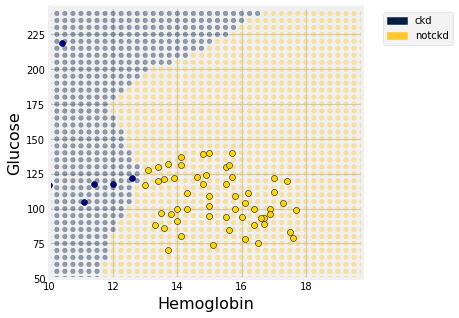

In [29]:
visualize_boundary(train_hgb_glc, hgb_glc_scaled_classifier,
                  np.arange(10, 20, .25), np.arange(50, 250, 5))

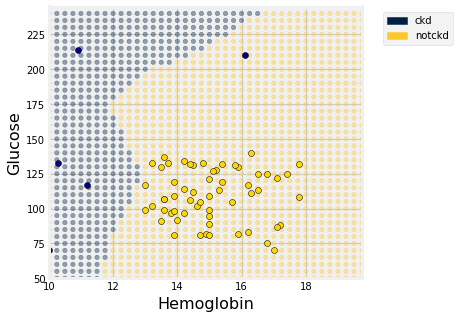

In [30]:
visualize_boundary(test_hgb_glc, hgb_glc_scaled_classifier,
                  np.arange(10, 20, .25), np.arange(50, 250, 5))

In [31]:
def classifier_accuracy(test, classifier):
    """Evaluate the accuracy of the classifier using the
    provided test table, whose last column should be
    the labels.  The names of the columns are irrelevant."""
    
    last_column = test.num_columns - 1
    actual_labels = test.column(last_column)
    predicted_labels = test.drop(last_column).apply(classifier)
    
    return np.mean(actual_labels == predicted_labels)    

In [32]:
classifier_accuracy(test_hgb_glc, hgb_glc_scaled_classifier)

0.98734177215189878

## Inference on classifier accuracy

In [33]:
def histogram_nn_classifier_accuracy(data, classifier_trainer, num_repetitions=NUM_REPETITIONS):
    """Visualize the empirical distribution of the accuracy
    of a classifier.  The data input is a table that will
    be split into test and training tables for each iteration
    The classifier_trainer is a function that takes a training 
    table as input, and returns a classifier function.  That 
    classifier function itself should take a new point as input 
    and return the classification of that point."""

    accuracies = make_array()
    
    for _ in np.arange(num_repetitions):
        shuffled = data.sample(with_replacement=False)
        half = int(data.num_rows / 2)
        train = shuffled.take(np.arange(0, half))
        test = shuffled.take(np.arange(half, data.num_rows))
        
        trained_classifier = classifier_trainer(train)
        acc = classifier_accuracy(test, trained_classifier)
        accuracies = np.append(accuracies, acc)
        
    left = percentile(2.5, accuracies)
    right = percentile(97.5, accuracies)
    
    Table().with_column(
        'Accuracy', accuracies
    ).hist()
    #plots.plot([left,right], [0,0], color='yellow', lw=8)

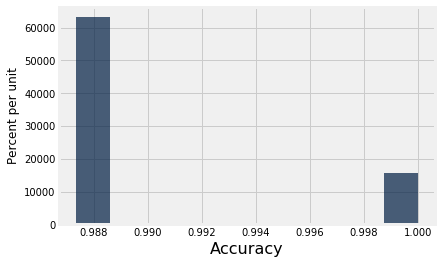

In [34]:
histogram_nn_classifier_accuracy(hgb_glc, train_nn_su_classifier)

**Was scaling helpful?**

In [35]:
def train_nn_classifier(train):
    """Create a nearest-neighbor classifier.  The last column 
    of the training table should be the labels, and the preceeding
    column should be the attributes.  The names of the columns do not
    matter.  
    
    Returns a function.  That function takes as input a 
    new point, which should be an array with two items,
    the x and y value of the new point, in that order.
    And the function returns the classification of
    the new point as output."""
    
    def classify_new_point(new_point):
        def distance_from_new(row):
            return distance(np.array(row), new_point)
    
        last_column = train.num_columns - 1
        
        distances = Table().with_columns(
            'Distance', train.drop(last_column).apply(distance_from_new),
            'Class', train.column(last_column)
        ).sort('Distance')
    
        return distances.column('Class').item(0)
    
    return classify_new_point

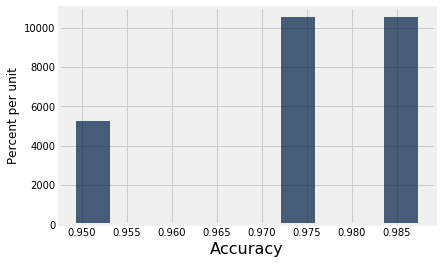

In [36]:
histogram_nn_classifier_accuracy(hgb_glc, train_nn_classifier)

Let's look at more than 5 repetitions...

**Q:** Was scaling helpful?

A.  Yes  
B.  No  

You do **not** need to worry about scaling and standard units in your proj3.